In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tqdm import tqdm 
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchsummary import summary
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b1

# Подготовка тренировочного датасета

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 2060
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [3]:
device

device(type='cuda')

In [5]:
pd.read_csv('/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv').head()

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6


In [3]:
categories = pd.read_csv('../data/activity_categories.csv')

categories.head()

,id,category
0,0,sports
1,1,inactivity quiet/light
2,2,miscellaneous
3,3,occupation
4,4,water activities


In [4]:
id_to_category = dict(zip(categories['id'], categories['category']))

In [5]:
class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (img_train).
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        """
        self.img_dir = img_dir
        self.files = os.listdir(self.img_dir)
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.files[idx]
        img_id =img_id.split('.')[0]
        # img_id1 = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        # label = self.labels.iloc[idx, 1]  # target_feature (метка)
        label = self.labels.loc[self.labels['img_id'] == int(img_id), 'target_feature'].values[0]

        # Загружаем изображение
        # img_path = os.path.join(self.img_dir, 'aug_'+str(img_id)+'.jpg')
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label, img_id
    
    def __len__(self):
        return len(self.files)


# Создание папки с аугментированными изображениями и ответами к ним

Перед аугментацией, разобъем наш датасет на две части

In [9]:
#Класс для разделения
class SplitPFileToVal:
    def __init__(self, path_to_dir, path_to_new_dir_val, path_to_new_dir_train, p:float):
        """
        Создаёт 2 новые папки: Для валидации - % от всех изображений, для трейна - все остальное. 
        Нужно для отделения части датасета, для val данных

        path_to_dir: Папка с изображениями. (img_train)
        path_to_new_dir_val: Путь до новой папки, можно не создавать вручную.
        path_to_new_dir_train: Путь до новой папки, можно не создавать вручную.
        p: % изображений, которые будут отделены для валидационного датасета
        """

        #Проверка, введеного %
        if not isinstance(p, float):
            raise TypeError("% должен быть float")
        if p <= 0 or p > 1:
            raise ValueError("% должен быть в диапозоне: 0 < p <= 1")
        self.p = p

        self.path_to_dir = path_to_dir
        self.files = os.listdir(self.path_to_dir)
        self.path_to_new_dir_val = path_to_new_dir_val
        self.path_to_new_dir_train = path_to_new_dir_train



        # Создаем папки для сохранения
        if os.path.exists(path_to_new_dir_val):
            shutil.rmtree(path_to_new_dir_val)  # Удаляем папку, если она уже существует
        os.makedirs(path_to_new_dir_val, exist_ok=True)

        if os.path.exists(path_to_new_dir_train):
            shutil.rmtree(path_to_new_dir_train)  # Удаляем папку, если она уже существует
        os.makedirs(path_to_new_dir_train, exist_ok=True)

    def split(self):
        len_val = int(len(self.files)*self.p)
        len_train = len(self.files) - len_val
        with tqdm(total=len_val, desc="Отделение валидационных данных", unit="img") as pbar:
            for _ in range(len_val):
                idx = random.randint(0, len(self.files) - 1)
                file = self.files[idx]
                path_to_file = self.path_to_dir+f'/{file}'
                shutil.copy(path_to_file, self.path_to_new_dir_val+f'/{file}')
                self.files.pop(idx)

                pbar.update(1)

        with tqdm(total=len_train, desc="Отделение тренировочных данных", unit="img") as pbar:
            for _ in range(len_train):
                idx = random.randint(0, len(self.files) - 1)
                file = self.files[idx]
                path_to_file = self.path_to_dir+f'/{file}'
                shutil.copy(path_to_file, self.path_to_new_dir_train+f'/{file}')
                self.files.pop(idx)
                
                pbar.update(1)

        print(f"\nОтделено {len_val} изображений, для валидации в папку: {self.path_to_new_dir_val}")
        print(f"Отделено {len_train} изображений, для тренировки в папку: {self.path_to_new_dir_train}")



In [10]:
#Использование разделения
spliter = SplitPFileToVal(
    path_to_dir='/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/img_train',
    path_to_new_dir_val='/kaggle/working/data/val_dataset',
    path_to_new_dir_train='/kaggle/working/data/train_dataset',
    p=0.1
)

spliter.split()

Отделение тренировочных данных: 100%|██████████| 11131/11131 [03:03<00:00, 60.67img/s]


Отделено 1236 изображений, для валидации в папку: /kaggle/working/data/val_dataset
Отделено 11131 изображений, для тренировки в папку: /kaggle/working/data/train_dataset


In [11]:
#Класс для создания аугментаций
class AugmentedDatasetSaver:
    def __init__(self, original_train_dataset, csv_path, augmentation_transform, new_train_dataset_path, output_csv_path, augment_count):
        """
        Создает и сохраняет аугментированный датасет из тренировочного.
        Также создает csv с ответами на аугментированный датасет, сохраняет ответы из train_answers

        original_train_dataset: Исходный датасет (torch Dataset).
        csv_path: путь к csv с ответами
        augmentation_transform: Трансформации для аугментации.
        new_train_dataset_path: Папка, куда будут сохранены данные.
        output_csv_path: Путь, куда будет сохранена csv
        augment_count: Количество аугментированных изображений, которые нужно создать.
        """
        self.original_train_dataset_path = original_train_dataset
        self.augmentation_transform = augmentation_transform
        self.new_train_dataset_path = new_train_dataset_path
        self.output_csv_path = output_csv_path
        self.original_labels = pd.read_csv(csv_path)

        
        if augment_count >= len(original_train_dataset):
            print("Введеный augment_count > длины датасета")
        self.augment_count = augment_count


        # Создаем папку для сохранения
        if os.path.exists(new_train_dataset_path):
            shutil.rmtree(new_train_dataset_path)  # Удаляем папку, если она уже существует
        os.makedirs(new_train_dataset_path, exist_ok=True)

    def save(self):
        new_entries = []
        max_id = self.original_labels['img_id'].max()
        with tqdm(total=self.augment_count, desc="Создание аугментированных данных", unit="img") as pbar:
            for i in range(self.augment_count):
                # Выбираем случайное изображение из оригинального датасета
                image, label, img_id = random.choice(self.original_train_dataset_path)

                # Преобразуем в тензор, если это PIL.Image
                if not isinstance(image, Image.Image):
                    raise ValueError(f"Unsupported image format: {type(image)}")

                # Применяем аугментацию
                augmented_image = self.augmentation_transform(image)

                

                # Генерируем имя файла, сохраняя оригинальное имя с префиксом
                img_id = max_id+i+1

                new_entries.append({'img_id': int(img_id), 'target_feature': label})

                img_save_path = os.path.join(self.new_train_dataset_path, f"{img_id}.jpg")

                # Преобразуем аугментированный тензор обратно в PIL.Image и сохраняем
                augmented_image = transforms.ToPILImage()(augmented_image)  # Перевод тензора в PIL
                augmented_image.save(img_save_path)

                pbar.update(1)
        # Создание DataFrame для новых данных
        augmented_df = pd.DataFrame(new_entries)
        combined_df = pd.concat([self.original_labels, augmented_df], ignore_index=True)
        combined_df.to_csv(self.output_csv_path, index=False)
        
        print(f"CSV файл с метками успешно сохранён в: {self.output_csv_path}")
        print(f"\nСохранено {self.augment_count} аугментированных изображений в папке: {self.new_train_dataset_path}")


In [12]:
#transform для аугментации
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=227, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=25), 
    transforms.ToTensor(),  # Преобразование в тензор для работы с RandomErasing
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3))
])

In [13]:
# Загружаем датасет, для тренировки
original_traint_dataset = HumanPoseDataset(
    img_dir='/kaggle/working/data/train_dataset',
    csv_file='/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv',
    transform=None  # Оставляем без изменений
)

# Папка для сохранения аугментированного датасета
save_dir = "/kaggle/working/data/augmented_only_dataset"

# Количество аугментированных изображений
augment_count = 11000 

# Создаем и сохраняем 
dataset_saver = AugmentedDatasetSaver(
    original_train_dataset=original_traint_dataset,
    augmentation_transform=augmentation_transform,
    csv_path='/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv',
    new_train_dataset_path=save_dir,
    augment_count=augment_count,
    output_csv_path='/kaggle/working/data/augmented_train_answers.csv'
)

In [14]:
# Создание аугментированных файлов
dataset_saver.save()

Создание аугментированных данных: 100%|██████████| 11000/11000 [04:51<00:00, 37.69img/s]

CSV файл с метками успешно сохранён в: /kaggle/working/data/augmented_train_answers.csv

Сохранено 11000 аугментированных изображений в папке: /kaggle/working/data/augmented_only_dataset


Проверка, что все создалось в нужном кол-ве

In [15]:
line_count = sum(1 for line in open('/kaggle/working/data/augmented_train_answers.csv')) - sum(1 for line in open('/kaggle/input/ml-intensive-yandex-academy-autumn-2024/human_poses_data/train_answers.csv'))
if augment_count == line_count:
    print('OK')
else:
    print(f'Ожидалось {augment_count}(augment_count)\n Получилось {line_count}(line_count)')

OK


In [16]:
aug_file_count = len(os.listdir("/kaggle/working/data/augmented_only_dataset"))
if augment_count == aug_file_count:
    print('OK')
else:
    print(f'Ожидалось {augment_count}(augment_count)\n Получилось {aug_file_count}(aug_file_count)')

OK


## Cоединение папки с аугментированными картинками и тренировочным датасетом в новую папку.

Удаляет папку по пути, который указан в path_augmented_only_dataset

In [17]:
def merge_folders(path_train_dataset, path_augmented_only_dataset, path_destination_folder):
    """
    Объединяет две папки с картинками в одну. УДАЛЯЕТ папку path_augmented_only_dataset

    :param path_train_dataset: Путь к первой исходной папке
    :param source_folder2: Путь ко второй исходной папке
    :param destination_folder: Путь к папке назначения
    """
    # Создаем папку назначения, если она не существует
    if os.path.exists(path_destination_folder):
        shutil.rmtree(path_destination_folder)  # Удаляем папку, если она уже существует
    os.makedirs(path_destination_folder, exist_ok=True)
    
    # Функция для копирования файлов из папки
    def copy_files_from_folder(folder):
        with tqdm(total=len(os.listdir(folder)), desc=f"Копирование из {folder}", unit="img") as pbar:
            for file_name in os.listdir(folder):
                source_path = os.path.join(folder, file_name)
                dest_path = os.path.join(path_destination_folder, file_name)
                
                # Проверяем, является ли элемент файлом
                if os.path.isfile(source_path):
                    if os.path.exists(dest_path):
                        raise KeyError('файл с таким именем уже существует в папке назначения')
                    shutil.copy2(source_path, dest_path)
                pbar.update(1)
    
    # Копируем файлы из обеих папок
    copy_files_from_folder(path_train_dataset)
    copy_files_from_folder(path_augmented_only_dataset)
    #Удаляем папку с аугментацией
    shutil.rmtree(path_augmented_only_dataset)

In [18]:
path_train_dataset = '/kaggle/working/data/train_dataset'
path_augmented_only_dataset = "/kaggle/working/data/augmented_only_dataset"
destination_folder = "/kaggle/working/data/augmented_and_train_dataset"

In [19]:
merge_folders(path_train_dataset, path_augmented_only_dataset, destination_folder)

Копирование из /kaggle/working/data/train_dataset: 100%|██████████| 11131/11131 [00:08<00:00, 1278.64img/s]
Копирование из /kaggle/working/data/augmented_only_dataset: 100%|██████████| 11000/11000 [00:01<00:00, 7548.67img/s]


In [20]:
expected_count = aug_file_count+len(os.listdir("/kaggle/working/data/train_dataset"))
quantity_count = len(os.listdir("/kaggle/working/data/augmented_and_train_dataset"))
if expected_count == quantity_count:
    print('OK')
else:
    print(f'Ожидалось {expected_count}(expected_count)\n Получилось {quantity_count}(quantity_count)')

OK


По итогу получилось:   
папка img_train -- картинки в оригинале,  
папка train_dataset -- часть датасета, для обучения,  
папка val_dataset -- часть датасета, для валидации,   
папка augmented_and_train_dataset -- augmented_only_dataset+img_train,   
augmented_train_answers.csv -- ответы на все папки  

# Начало работы с моделью

In [21]:
# RANDOM_SEED = 52
# generator = torch.Generator().manual_seed(RANDOM_SEED)

In [22]:
print(f"Available CPU cores: {os.cpu_count()}")

Available CPU cores: 4


In [6]:
# transform_train = transforms.Compose([
#     transforms.Resize((227, 227)), # тк в ауг датасете есть фото без аугментации
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
val_dataset = HumanPoseDataset(
    img_dir='../data/val_dataset',
    csv_file='../data/train_answers.csv',
    transform=transform
)

train_dataset = HumanPoseDataset(
    img_dir='../data/augmented_and_train_dataset',
    csv_file='../data/augmented_train_answers.csv',
    transform=transform
)



# train_dataset, _ = random_split(dataset_train, [int(0.9*len(dataset_train)), len(dataset_train) - int(0.9*len(dataset_train))], generator)
# _, val_dataset = random_split(dataset_val, [int(0.9*len(dataset_val)), len(dataset_val) - int(0.9*len(dataset_val))], generator)

In [8]:
import pandas as pd

# Загрузим CSV-файлы для валидационного и тренировочного датасетов
val_labels_df = pd.read_csv('../data/train_answers.csv')
train_labels_df = pd.read_csv('../data/augmented_train_answers.csv')

# Предположим, что метки классов в этих датафреймах хранятся в колонке 'label' или другой
# Замените 'label' на название колонки с метками в вашем случае
val_labels = val_labels_df['target_feature'].values
train_labels = train_labels_df['target_feature'].values

# Подсчитаем количество примеров для каждого класса в тренировочном датасете
train_class_counts = pd.Series(train_labels).value_counts().sort_index().to_dict()

# Подсчитаем количество примеров для каждого класса в валидационном датасете
val_class_counts = pd.Series(val_labels).value_counts().sort_index().to_dict()

# Выведем количество примеров для каждого класса
print(f"Train class counts:\n{train_class_counts}")
print(f"Validation class counts:\n{val_class_counts}")


Train class counts:
{0: 4764, 1: 273, 2: 1053, 3: 3197, 4: 1386, 5: 1864, 6: 1527, 8: 990, 9: 2305, 10: 739, 11: 984, 12: 892, 13: 821, 14: 419, 16: 1428, 18: 725}
Validation class counts:
{0: 2512, 1: 135, 2: 530, 3: 1680, 4: 752, 5: 982, 6: 800, 8: 533, 9: 1223, 10: 390, 11: 528, 12: 469, 13: 442, 14: 228, 16: 753, 18: 410}


In [9]:
total_train_samples = sum(train_class_counts.values())
total_val_samples = sum(val_class_counts.values())

# Веса для классов в тренировочном и валидационном датасетах
train_class_weights = {k: total_train_samples / v for k, v in train_class_counts.items()}
val_class_weights = {k: total_val_samples / v for k, v in val_class_counts.items()}

# Выводим веса для классов
print("Train class weights:", train_class_weights)
print("Validation class weights:", val_class_weights)

Train class weights: {0: 4.904911838790932, 1: 85.5934065934066, 2: 22.19088319088319, 3: 7.309039724741946, 4: 16.85930735930736, 5: 12.535944206008583, 6: 15.302554027504911, 8: 23.6030303030303, 9: 10.137527114967462, 10: 31.619756427604873, 11: 23.746951219512194, 12: 26.196188340807176, 13: 28.46163215590743, 14: 55.76849642004773, 16: 16.363445378151262, 18: 32.23034482758621}
Validation class weights: {0: 4.923168789808917, 1: 91.60740740740741, 2: 23.333962264150944, 3: 7.361309523809524, 4: 16.445478723404257, 5: 12.59368635437882, 6: 15.45875, 8: 23.202626641651033, 9: 10.112019623875716, 10: 31.71025641025641, 11: 23.422348484848484, 12: 26.368869936034116, 13: 27.979638009049772, 14: 54.24122807017544, 16: 16.42363877822045, 18: 30.163414634146342}


In [27]:
train_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [28]:
# Функция для отображения изображений с подписями
def show_images_with_labels(dataset, id_to_category, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Достаем изображение и метку
        image, label, img_id= dataset[i]
        # img_name = dataset.labels.iloc[i, 0]  # Имя файла

        # Декодируем метку в категорию
        category = id_to_category[label] if id_to_category else label

        # # Отображаем изображение
        axes[i].imshow(image.permute(1, 2, 0))  # Преобразуем тензор в (H, W, C)

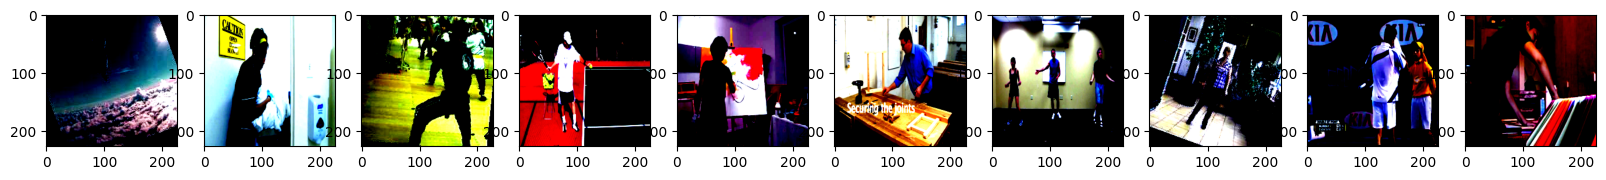

In [29]:
# Вывести первые 5 изображений в одну строку
show_images_with_labels(train_dataset, id_to_category, 10)

# Архитектуры

In [30]:
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(nn.functional.softplus(x))

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mish = Mish()
        self.group_norm1 = nn.GroupNorm(32, out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.group_norm2 = nn.GroupNorm(32, out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)

        self.se_block = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.mish(out)
        out = self.group_norm1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.mish(out)
        out = self.group_norm2(out)
        out = self.dropout2(out)

        out = self.se_block(out)
        out += identity
        out = self.mish(out)
        return out

class UpdatedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=20, dropout_prob=0.5):
        super(UpdatedResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mish = Mish()
        self.group_norm = nn.GroupNorm(32, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.3):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(32, out_channels)
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_prob=dropout_prob))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_prob=dropout_prob))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mish(x)
        x = self.group_norm(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def custom_resnet18(num_classes=20, dropout_prob=0.3):
    return UpdatedResNet(ResidualBlock, [2, 2, 2, 2], num_classes, dropout_prob)


In [31]:
import torch.nn.functional as F
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.2):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mish = Mish()
        self.group_norm1 = nn.GroupNorm(32, out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.group_norm2 = nn.GroupNorm(32, out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)

        self.se_block = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.mish(out)
        out = self.group_norm1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.mish(out)
        out = self.group_norm2(out)
        out = self.dropout2(out)

        out = self.se_block(out)
        out += identity
        out = self.mish(out)
        return out

class UpdatedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=20, dropout_prob=0.2):
        super(UpdatedResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mish = Mish()
        self.group_norm = nn.GroupNorm(32, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.2):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(32, out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_prob=dropout_prob))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_prob=dropout_prob))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mish(x)
        x = self.group_norm(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def custom_resnet18(num_classes=20, dropout_prob=0.2):
    return UpdatedResNet(ResidualBlock, [2, 2, 2, 2], num_classes, dropout_prob)

In [10]:

from torchvision.models import efficientnet_b0
from torchsummary import summary

In [12]:

import torch.nn as nn
from torchvision import models

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=20):
        super(CustomEfficientNet, self).__init__()

        # Загрузка базовой модели EfficientNet-B0 без предобученных весов
        self.base_model = models.efficientnet_b0(pretrained=False)

        # Добавление дополнительных сверточных слоев и Batch Normalization
        # Сначала добавляем дополнительные сверточные слои и Batch Normalization
        self.extra_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=1, stride=1),  # Identity mapping
            nn.ReLU(inplace=True)
        )


        # Обновляем первый слой базовой модели для использования 64 каналов (после добавленных слоев)
        self.base_model.features[0][0] = nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1)

        # Заменяем последний классификатор для 20 классов
        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),  # Увеличиваем dropout
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        # Применяем дополнительные слои перед базовой моделью
        x = self.extra_conv(x)
        
        # Дальше передаем результат в базовую модель
        return self.base_model(x)

def custom_efficientnet_b0(num_classes=20):
    return CustomEfficientNet(num_classes=num_classes)

In [13]:
import gc
import torch

# Assuming `obj` is the object consuming GPU memory
obj = None

# Collect garbage
gc.collect()

# Empty PyTorch cache
torch.cuda.empty_cache()

In [14]:
model = custom_efficientnet_b0(num_classes=20).to(device)

/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [156]:
len(id_to_category)

20

In [157]:
model = custom_efficientnet_b0(num_classes=20)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, (3, 227, 227))

dummy_input = torch.randn(1, 3, 227, 227).to(device)

output = model(dummy_input)
print(output.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 227, 227]             896
       BatchNorm2d-2         [-1, 32, 227, 227]              64
              ReLU-3         [-1, 32, 227, 227]               0
            Conv2d-4         [-1, 64, 227, 227]          18,496
       BatchNorm2d-5         [-1, 64, 227, 227]             128
              ReLU-6         [-1, 64, 227, 227]               0
            Conv2d-7         [-1, 64, 227, 227]           4,160
              ReLU-8         [-1, 64, 227, 227]               0
            Conv2d-9         [-1, 32, 114, 114]          18,464
      BatchNorm2d-10         [-1, 32, 114, 114]              64
             SiLU-11         [-1, 32, 114, 114]               0
           Conv2d-12         [-1, 32, 114, 114]             288
      BatchNorm2d-13         [-1, 32, 114, 114]              64
             SiLU-14         [-1, 32, 1

In [15]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
import logging
from ignite.metrics import Precision, Recall

/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [15]:
model = custom_efficientnet_b0(num_classes=20).to(device)

/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
# Определение функции потерь и оптимизатора
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
weight_decay = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=3)

In [16]:
import time

time.localtime()

time.struct_time(tm_year=2024, tm_mon=12, tm_mday=17, tm_hour=19, tm_min=24, tm_sec=14, tm_wday=1, tm_yday=352, tm_isdst=0)

In [17]:
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min',  # Или 'max', если метрика должна увеличиваться
#     factor=0.75,  # Во сколько раз уменьшать learning rate
#     patience=1,  # Сколько эпох ждать улучшений
#     verbose=True,  # Выводить сообщения о снижении learning rate
#     min_lr=1e-6  # Минимальное значение learning rate
# )

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [21]:
import os
import time
import logging
import pandas as pd
import torch
from ignite.engine import Engine, Events
from ignite.metrics import Precision, Recall, Loss, MetricsLambda
from ignite.handlers import EarlyStopping, Checkpoint, DiskSaver, global_step_from_engine
from ignite.contrib.handlers import ProgressBar


# Функция для вычисления взвешенного F1
def weighted_f1_from_tensor(f1_tensor, class_weights):
    # Преобразуем веса классов в список
    class_weights_tensor = torch.tensor([class_weights.get(i, 0) for i in range(len(f1_tensor))], dtype=torch.float32)

    # Массив F1 для классов, которые присутствуют в данных
    f1_values = f1_tensor[class_weights_tensor > 0]  # Фильтруем классы с нулевыми весами
    class_weights_values = class_weights_tensor[class_weights_tensor > 0]

    if len(f1_values) == 0:  # Если нет классов с ненулевыми весами
        return 0.0

    # Рассчитываем взвешенный F1
    weighted_f1 = torch.sum(f1_values * class_weights_values) / torch.sum(class_weights_values)
    return weighted_f1.item()

# Определяем одну итерацию обучения (тренировочный шаг)
def train_step(engine, batch):
    model.train()
    images, labels, img_id = batch
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return {"loss": loss.item(), "outputs": outputs, "labels": labels}

# Определяем одну итерацию валидации
def val_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels, img_id = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        return {"outputs": outputs, "labels": labels}

# Создаём движки для тренировки и валидации
trainer = Engine(train_step)
evaluator = Engine(val_step)

# Определяем метрики Precision, Recall и F1
precision = Precision(average=False, output_transform=lambda x: (x["outputs"], x["labels"]))
recall = Recall(average=False, output_transform=lambda x: (x["outputs"], x["labels"]))
f1 = MetricsLambda(lambda p, r: 2 * (p * r) / (p + r + 1e-9), precision, recall)

# Добавляем метрики к тренеру и валидатору
train_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
train_loss.attach(trainer, "loss")
precision.attach(trainer, "precision")
recall.attach(trainer, "recall")
f1.attach(trainer, "F1")

eval_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
eval_loss.attach(evaluator, "loss")
precision.attach(evaluator, "precision")
recall.attach(evaluator, "recall")
f1.attach(evaluator, "F1")

# # Обработчик ранней остановки
# handler = EarlyStopping(
#     patience=10,
#     score_function=lambda engine: -engine.state.metrics["loss"],  # Отслеживаем метрику потерь
#     trainer=trainer,
#     min_delta=0.01
# )
# evaluator.add_event_handler(Events.COMPLETED, handler)

# Прогресс-бар
ProgressBar().attach(trainer)
ProgressBar().attach(evaluator)

# Логирование
cur_time = time.localtime()
path_suf = f'_{cur_time.tm_mday}_{cur_time.tm_mon}_{cur_time.tm_hour}_{cur_time.tm_min}'

log_dir = "./train_info/logs" + path_suf
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "training.log"),
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
)
logger = logging.getLogger()

# Сохраняем метрики в DataFrame
metrics_path = os.path.join(log_dir, "metrics.csv")
if os.path.exists(metrics_path):
    metrics_df = pd.read_csv(metrics_path)
else:
    metrics_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train F1", "Validation Loss", "Validation F1"])

# Сохранение модели
to_save = {"model": model, "optimizer": optimizer, "trainer": trainer}
checkpoint_handler = Checkpoint(
    to_save,
    DiskSaver("./train_info/checkpoints" + path_suf, create_dir=True, require_empty=False, atomic=False),
    n_saved=3,
    filename_prefix="best",
    score_function=lambda engine: weighted_f1_from_tensor(engine.state.metrics["F1"], train_class_weights),  # Применяем weighted F1
    score_name="val_F1",
    global_step_transform=global_step_from_engine(trainer),
)


@trainer.on(Events.EPOCH_COMPLETED)
def log_and_save_metrics(engine):
    # Логируем метрики тренировки
    train_metrics = engine.state.metrics
    train_loss = train_metrics["loss"]
    train_F1 = train_metrics["F1"]

    # Запускаем валидацию
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_F1 = val_metrics["F1"]
    
    # Рассчитываем взвешенные F1
    weighted_train_f1 = weighted_f1_from_tensor(train_F1, train_class_weights)
    weighted_val_f1 = weighted_f1_from_tensor(val_F1, val_class_weights)


    # Логируем результаты
    logger.info(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Weighted F1: {weighted_train_f1:.4f}, "
                f"Validation Loss: {val_loss:.4f}, Validation Weighted F1: {weighted_val_f1:.4f}")
    print(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Weighted F1: {weighted_train_f1:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Weighted F1: {weighted_val_f1:.4f}")

    # Сохраняем метрики в DataFrame
    global metrics_df
    metrics_df = pd.concat(
        [metrics_df, pd.DataFrame({
            "Epoch": [engine.state.epoch],
            "Train Loss": [train_loss],
            "Train F1": [train_F1],
            "Validation Loss": [val_loss],
            "Validation F1": [val_F1],
        })],
        ignore_index=True
    )
    metrics_df.to_csv(metrics_path, index=False)

    # Сохраняем модель
    checkpoint_handler(evaluator)

# Логируем изменения learning rate и weight decay
@trainer.on(Events.EPOCH_COMPLETED)
def log_lr_and_threshold(engine):
    current_lr = optimizer.param_groups[0]["lr"]
    logger.info(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}")
    print(f"Epoch {engine.state.epoch}: Learning Rate: {current_lr:.6f}")


/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [22]:
# weight_decay = 1e-4
trainer.run(train_loader, max_epochs=150)

# Полный output обучения можно посмотреть в traning.log

/tmp/ipykernel_10828/2064936633.py:143: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat(


Epoch 1: Train Loss: 0.7223, Train Weighted F1: 0.9750, Validation Loss: 1.5438, Validation Weighted F1: 0.5247
Epoch 1: Learning Rate: 0.001000


Epoch 2: Train Loss: 0.7234, Train Weighted F1: 0.9717, Validation Loss: 1.6057, Validation Weighted F1: 0.4749
Epoch 2: Learning Rate: 0.001000


Epoch 3: Train Loss: 0.7217, Train Weighted F1: 0.9725, Validation Loss: 1.5819, Validation Weighted F1: 0.5257
Epoch 3: Learning Rate: 0.001000


Epoch 4: Train Loss: 0.7149, Train Weighted F1: 0.9749, Validation Loss: 1.5902, Validation Weighted F1: 0.5415
Epoch 4: Learning Rate: 0.001000


Epoch 5: Train Loss: 0.7132, Train Weighted F1: 0.9753, Validation Loss: 1.5762, Validation Weighted F1: 0.5284
Epoch 5: Learning Rate: 0.001000


Epoch 6: Train Loss: 0.6948, Train Weighted F1: 0.9827, Validation Loss: 1.6019, Validation Weighted F1: 0.5253
Epoch 6: Learning Rate: 0.001000


Epoch 7: Train Loss: 0.7101, Train Weighted F1: 0.9748, Validation Loss: 1.5573, Validation Weighted F1: 0.5659
Epoch 7: Learning Rate: 0.001000


Epoch 8: Train Loss: 0.7022, Train Weighted F1: 0.9789, Validation Loss: 1.5358, Validation Weighted F1: 0.5561
Epoch 8: Learning Rate: 0.001000


Epoch 9: Train Loss: 0.7016, Train Weighted F1: 0.9777, Validation Loss: 1.5624, Validation Weighted F1: 0.5689
Epoch 9: Learning Rate: 0.001000


Epoch 10: Train Loss: 0.6983, Train Weighted F1: 0.9771, Validation Loss: 1.6120, Validation Weighted F1: 0.5579
Epoch 10: Learning Rate: 0.001000


Epoch 11: Train Loss: 0.6962, Train Weighted F1: 0.9787, Validation Loss: 1.5550, Validation Weighted F1: 0.5593
Epoch 11: Learning Rate: 0.001000


Epoch 12: Train Loss: 0.6899, Train Weighted F1: 0.9824, Validation Loss: 1.5252, Validation Weighted F1: 0.5383
Epoch 12: Learning Rate: 0.001000


Epoch 13: Train Loss: 0.6850, Train Weighted F1: 0.9821, Validation Loss: 1.5564, Validation Weighted F1: 0.5342
Epoch 13: Learning Rate: 0.001000


Epoch 14: Train Loss: 0.6888, Train Weighted F1: 0.9793, Validation Loss: 1.5416, Validation Weighted F1: 0.5454
Epoch 14: Learning Rate: 0.001000


Epoch 15: Train Loss: 0.6837, Train Weighted F1: 0.9823, Validation Loss: 1.5691, Validation Weighted F1: 0.5220
Epoch 15: Learning Rate: 0.001000


Epoch 16: Train Loss: 0.6884, Train Weighted F1: 0.9841, Validation Loss: 1.5687, Validation Weighted F1: 0.4835
Epoch 16: Learning Rate: 0.001000


Epoch 17: Train Loss: 0.6823, Train Weighted F1: 0.9850, Validation Loss: 1.5348, Validation Weighted F1: 0.5710
Epoch 17: Learning Rate: 0.001000


Epoch 18: Train Loss: 0.6791, Train Weighted F1: 0.9837, Validation Loss: 1.5242, Validation Weighted F1: 0.5161
Epoch 18: Learning Rate: 0.001000


Epoch 19: Train Loss: 0.6778, Train Weighted F1: 0.9837, Validation Loss: 1.5307, Validation Weighted F1: 0.5144
Epoch 19: Learning Rate: 0.001000


Epoch 20: Train Loss: 0.6813, Train Weighted F1: 0.9810, Validation Loss: 1.5609, Validation Weighted F1: 0.5442
Epoch 20: Learning Rate: 0.001000


Epoch 21: Train Loss: 0.6753, Train Weighted F1: 0.9849, Validation Loss: 1.5506, Validation Weighted F1: 0.5446
Epoch 21: Learning Rate: 0.001000


Epoch 22: Train Loss: 0.6741, Train Weighted F1: 0.9846, Validation Loss: 1.5921, Validation Weighted F1: 0.5527
Epoch 22: Learning Rate: 0.001000


Epoch 23: Train Loss: 0.6758, Train Weighted F1: 0.9849, Validation Loss: 1.5576, Validation Weighted F1: 0.5407
Epoch 23: Learning Rate: 0.001000


Epoch 24: Train Loss: 0.6692, Train Weighted F1: 0.9862, Validation Loss: 1.5815, Validation Weighted F1: 0.5461
Epoch 24: Learning Rate: 0.001000


Epoch 25: Train Loss: 0.6718, Train Weighted F1: 0.9853, Validation Loss: 1.5660, Validation Weighted F1: 0.5307
Epoch 25: Learning Rate: 0.001000


Epoch 26: Train Loss: 0.6739, Train Weighted F1: 0.9812, Validation Loss: 1.5520, Validation Weighted F1: 0.5483
Epoch 26: Learning Rate: 0.001000


Epoch 27: Train Loss: 0.6666, Train Weighted F1: 0.9856, Validation Loss: 1.5634, Validation Weighted F1: 0.5657
Epoch 27: Learning Rate: 0.001000


Epoch 28: Train Loss: 0.6647, Train Weighted F1: 0.9852, Validation Loss: 1.5440, Validation Weighted F1: 0.5503
Epoch 28: Learning Rate: 0.001000


Epoch 29: Train Loss: 0.6669, Train Weighted F1: 0.9836, Validation Loss: 1.5533, Validation Weighted F1: 0.5445
Epoch 29: Learning Rate: 0.001000


Epoch 30: Train Loss: 0.6659, Train Weighted F1: 0.9872, Validation Loss: 1.5818, Validation Weighted F1: 0.5202
Epoch 30: Learning Rate: 0.001000


Epoch 31: Train Loss: 0.6748, Train Weighted F1: 0.9831, Validation Loss: 1.5613, Validation Weighted F1: 0.5259
Epoch 31: Learning Rate: 0.001000


Epoch 32: Train Loss: 0.6558, Train Weighted F1: 0.9887, Validation Loss: 1.5539, Validation Weighted F1: 0.5757
Epoch 32: Learning Rate: 0.001000


Epoch 33: Train Loss: 0.6604, Train Weighted F1: 0.9873, Validation Loss: 1.5681, Validation Weighted F1: 0.5161
Epoch 33: Learning Rate: 0.001000


Epoch 34: Train Loss: 0.6678, Train Weighted F1: 0.9824, Validation Loss: 1.5618, Validation Weighted F1: 0.5195
Epoch 34: Learning Rate: 0.001000


Epoch 35: Train Loss: 0.6640, Train Weighted F1: 0.9849, Validation Loss: 1.5511, Validation Weighted F1: 0.5447
Epoch 35: Learning Rate: 0.001000


Epoch 36: Train Loss: 0.6601, Train Weighted F1: 0.9862, Validation Loss: 1.5238, Validation Weighted F1: 0.5655
Epoch 36: Learning Rate: 0.001000


Epoch 37: Train Loss: 0.6589, Train Weighted F1: 0.9853, Validation Loss: 1.6179, Validation Weighted F1: 0.5470
Epoch 37: Learning Rate: 0.001000


Epoch 38: Train Loss: 0.6648, Train Weighted F1: 0.9845, Validation Loss: 1.6235, Validation Weighted F1: 0.4711
Epoch 38: Learning Rate: 0.001000


Epoch 39: Train Loss: 0.6613, Train Weighted F1: 0.9856, Validation Loss: 1.5828, Validation Weighted F1: 0.5067
Epoch 39: Learning Rate: 0.001000


Epoch 40: Train Loss: 0.6556, Train Weighted F1: 0.9858, Validation Loss: 1.5980, Validation Weighted F1: 0.5479
Epoch 40: Learning Rate: 0.001000


Epoch 41: Train Loss: 0.6601, Train Weighted F1: 0.9873, Validation Loss: 1.5547, Validation Weighted F1: 0.5719
Epoch 41: Learning Rate: 0.001000


Epoch 42: Train Loss: 0.6599, Train Weighted F1: 0.9835, Validation Loss: 1.5784, Validation Weighted F1: 0.5556
Epoch 42: Learning Rate: 0.001000


Epoch 43: Train Loss: 0.6532, Train Weighted F1: 0.9860, Validation Loss: 1.5658, Validation Weighted F1: 0.5573
Epoch 43: Learning Rate: 0.001000


Epoch 44: Train Loss: 0.6581, Train Weighted F1: 0.9851, Validation Loss: 1.5212, Validation Weighted F1: 0.5656
Epoch 44: Learning Rate: 0.001000


Epoch 45: Train Loss: 0.6516, Train Weighted F1: 0.9886, Validation Loss: 1.4960, Validation Weighted F1: 0.5612
Epoch 45: Learning Rate: 0.001000


Epoch 46: Train Loss: 0.6616, Train Weighted F1: 0.9823, Validation Loss: 1.5928, Validation Weighted F1: 0.5496
Epoch 46: Learning Rate: 0.001000


Epoch 47: Train Loss: 0.6483, Train Weighted F1: 0.9905, Validation Loss: 1.5634, Validation Weighted F1: 0.5838
Epoch 47: Learning Rate: 0.001000


Epoch 48: Train Loss: 0.6558, Train Weighted F1: 0.9850, Validation Loss: 1.5681, Validation Weighted F1: 0.5905
Epoch 48: Learning Rate: 0.001000


Epoch 49: Train Loss: 0.6492, Train Weighted F1: 0.9871, Validation Loss: 1.5507, Validation Weighted F1: 0.5483
Epoch 49: Learning Rate: 0.001000


Epoch 50: Train Loss: 0.6560, Train Weighted F1: 0.9859, Validation Loss: 1.5872, Validation Weighted F1: 0.5352
Epoch 50: Learning Rate: 0.001000


Epoch 51: Train Loss: 0.6532, Train Weighted F1: 0.9874, Validation Loss: 1.5897, Validation Weighted F1: 0.5100
Epoch 51: Learning Rate: 0.001000


Epoch 52: Train Loss: 0.6509, Train Weighted F1: 0.9859, Validation Loss: 1.5867, Validation Weighted F1: 0.5834
Epoch 52: Learning Rate: 0.001000


Epoch 53: Train Loss: 0.6511, Train Weighted F1: 0.9888, Validation Loss: 1.5678, Validation Weighted F1: 0.5702
Epoch 53: Learning Rate: 0.001000


Epoch 54: Train Loss: 0.6466, Train Weighted F1: 0.9878, Validation Loss: 1.5540, Validation Weighted F1: 0.5945
Epoch 54: Learning Rate: 0.001000


Epoch 55: Train Loss: 0.6502, Train Weighted F1: 0.9869, Validation Loss: 1.5529, Validation Weighted F1: 0.5413
Epoch 55: Learning Rate: 0.001000


Epoch 56: Train Loss: 0.6508, Train Weighted F1: 0.9859, Validation Loss: 1.5794, Validation Weighted F1: 0.5495
Epoch 56: Learning Rate: 0.001000


Epoch 57: Train Loss: 0.6512, Train Weighted F1: 0.9877, Validation Loss: 1.5946, Validation Weighted F1: 0.5477
Epoch 57: Learning Rate: 0.001000


Epoch 58: Train Loss: 0.6444, Train Weighted F1: 0.9889, Validation Loss: 1.5384, Validation Weighted F1: 0.5622
Epoch 58: Learning Rate: 0.001000


Epoch 59: Train Loss: 0.6437, Train Weighted F1: 0.9880, Validation Loss: 1.5755, Validation Weighted F1: 0.5793
Epoch 59: Learning Rate: 0.001000


Epoch 60: Train Loss: 0.6522, Train Weighted F1: 0.9826, Validation Loss: 1.6027, Validation Weighted F1: 0.5744
Epoch 60: Learning Rate: 0.001000


Epoch 61: Train Loss: 0.6519, Train Weighted F1: 0.9860, Validation Loss: 1.5448, Validation Weighted F1: 0.5418
Epoch 61: Learning Rate: 0.001000


Epoch 62: Train Loss: 0.6464, Train Weighted F1: 0.9880, Validation Loss: 1.5457, Validation Weighted F1: 0.5771
Epoch 62: Learning Rate: 0.001000


Epoch 63: Train Loss: 0.6444, Train Weighted F1: 0.9904, Validation Loss: 1.5875, Validation Weighted F1: 0.5639
Epoch 63: Learning Rate: 0.001000


Epoch 64: Train Loss: 0.6418, Train Weighted F1: 0.9884, Validation Loss: 1.5716, Validation Weighted F1: 0.5506
Epoch 64: Learning Rate: 0.001000


Epoch 65: Train Loss: 0.6441, Train Weighted F1: 0.9862, Validation Loss: 1.6392, Validation Weighted F1: 0.5194
Epoch 65: Learning Rate: 0.001000


Epoch 66: Train Loss: 0.6467, Train Weighted F1: 0.9877, Validation Loss: 1.5244, Validation Weighted F1: 0.5663
Epoch 66: Learning Rate: 0.001000


Epoch 67: Train Loss: 0.6431, Train Weighted F1: 0.9871, Validation Loss: 1.5694, Validation Weighted F1: 0.5485
Epoch 67: Learning Rate: 0.001000


Epoch 68: Train Loss: 0.6447, Train Weighted F1: 0.9874, Validation Loss: 1.5797, Validation Weighted F1: 0.5704
Epoch 68: Learning Rate: 0.001000


Epoch 69: Train Loss: 0.6478, Train Weighted F1: 0.9876, Validation Loss: 1.5915, Validation Weighted F1: 0.5715
Epoch 69: Learning Rate: 0.001000


Epoch 70: Train Loss: 0.6419, Train Weighted F1: 0.9863, Validation Loss: 1.5615, Validation Weighted F1: 0.5789
Epoch 70: Learning Rate: 0.001000


Epoch 71: Train Loss: 0.6442, Train Weighted F1: 0.9888, Validation Loss: 1.6246, Validation Weighted F1: 0.5179
Epoch 71: Learning Rate: 0.001000


Epoch 72: Train Loss: 0.6469, Train Weighted F1: 0.9882, Validation Loss: 1.5884, Validation Weighted F1: 0.5748
Epoch 72: Learning Rate: 0.001000


Epoch 73: Train Loss: 0.6388, Train Weighted F1: 0.9895, Validation Loss: 1.5806, Validation Weighted F1: 0.5769
Epoch 73: Learning Rate: 0.001000


Epoch 74: Train Loss: 0.6435, Train Weighted F1: 0.9887, Validation Loss: 1.5780, Validation Weighted F1: 0.5533
Epoch 74: Learning Rate: 0.001000


Epoch 75: Train Loss: 0.6443, Train Weighted F1: 0.9871, Validation Loss: 1.5493, Validation Weighted F1: 0.5900
Epoch 75: Learning Rate: 0.001000


Epoch 76: Train Loss: 0.6408, Train Weighted F1: 0.9871, Validation Loss: 1.5206, Validation Weighted F1: 0.5781
Epoch 76: Learning Rate: 0.001000


Epoch 77: Train Loss: 0.6400, Train Weighted F1: 0.9881, Validation Loss: 1.5690, Validation Weighted F1: 0.5887
Epoch 77: Learning Rate: 0.001000


Epoch 78: Train Loss: 0.6399, Train Weighted F1: 0.9883, Validation Loss: 1.5591, Validation Weighted F1: 0.5862
Epoch 78: Learning Rate: 0.001000


Epoch 79: Train Loss: 0.6403, Train Weighted F1: 0.9889, Validation Loss: 1.5591, Validation Weighted F1: 0.5616
Epoch 79: Learning Rate: 0.001000


Epoch 80: Train Loss: 0.6399, Train Weighted F1: 0.9873, Validation Loss: 1.5957, Validation Weighted F1: 0.5425
Epoch 80: Learning Rate: 0.001000


Epoch 81: Train Loss: 0.6402, Train Weighted F1: 0.9878, Validation Loss: 1.5985, Validation Weighted F1: 0.5667
Epoch 81: Learning Rate: 0.001000


Epoch 82: Train Loss: 0.6457, Train Weighted F1: 0.9853, Validation Loss: 1.5946, Validation Weighted F1: 0.5724
Epoch 82: Learning Rate: 0.001000


Epoch 83: Train Loss: 0.6389, Train Weighted F1: 0.9901, Validation Loss: 1.5684, Validation Weighted F1: 0.5796
Epoch 83: Learning Rate: 0.001000


Epoch 84: Train Loss: 0.6361, Train Weighted F1: 0.9919, Validation Loss: 1.6058, Validation Weighted F1: 0.5790
Epoch 84: Learning Rate: 0.001000


Epoch 85: Train Loss: 0.6390, Train Weighted F1: 0.9887, Validation Loss: 1.5787, Validation Weighted F1: 0.5347
Epoch 85: Learning Rate: 0.001000


Epoch 86: Train Loss: 0.6409, Train Weighted F1: 0.9882, Validation Loss: 1.6197, Validation Weighted F1: 0.5837
Epoch 86: Learning Rate: 0.001000


Epoch 87: Train Loss: 0.6372, Train Weighted F1: 0.9887, Validation Loss: 1.5900, Validation Weighted F1: 0.5670
Epoch 87: Learning Rate: 0.001000


Epoch 88: Train Loss: 0.6388, Train Weighted F1: 0.9911, Validation Loss: 1.5965, Validation Weighted F1: 0.5583
Epoch 88: Learning Rate: 0.001000


Epoch 89: Train Loss: 0.6371, Train Weighted F1: 0.9888, Validation Loss: 1.6005, Validation Weighted F1: 0.5943
Epoch 89: Learning Rate: 0.001000


Epoch 90: Train Loss: 0.6402, Train Weighted F1: 0.9883, Validation Loss: 1.5963, Validation Weighted F1: 0.6000
Epoch 90: Learning Rate: 0.001000


Epoch 91: Train Loss: 0.6363, Train Weighted F1: 0.9893, Validation Loss: 1.6076, Validation Weighted F1: 0.5851
Epoch 91: Learning Rate: 0.001000


Epoch 92: Train Loss: 0.6367, Train Weighted F1: 0.9893, Validation Loss: 1.5831, Validation Weighted F1: 0.5404
Epoch 92: Learning Rate: 0.001000


Epoch 93: Train Loss: 0.6373, Train Weighted F1: 0.9894, Validation Loss: 1.6007, Validation Weighted F1: 0.5823
Epoch 93: Learning Rate: 0.001000


Epoch 94: Train Loss: 0.6397, Train Weighted F1: 0.9878, Validation Loss: 1.6033, Validation Weighted F1: 0.5456
Epoch 94: Learning Rate: 0.001000


Epoch 95: Train Loss: 0.6360, Train Weighted F1: 0.9897, Validation Loss: 1.6317, Validation Weighted F1: 0.5503
Epoch 95: Learning Rate: 0.001000


Epoch 96: Train Loss: 0.6320, Train Weighted F1: 0.9907, Validation Loss: 1.5817, Validation Weighted F1: 0.5730
Epoch 96: Learning Rate: 0.001000


Epoch 97: Train Loss: 0.6393, Train Weighted F1: 0.9885, Validation Loss: 1.5743, Validation Weighted F1: 0.5553
Epoch 97: Learning Rate: 0.001000


Epoch 98: Train Loss: 0.6346, Train Weighted F1: 0.9902, Validation Loss: 1.6608, Validation Weighted F1: 0.5569
Epoch 98: Learning Rate: 0.001000


Epoch 99: Train Loss: 0.6376, Train Weighted F1: 0.9903, Validation Loss: 1.5887, Validation Weighted F1: 0.5514
Epoch 99: Learning Rate: 0.001000


Epoch 100: Train Loss: 0.6309, Train Weighted F1: 0.9915, Validation Loss: 1.6123, Validation Weighted F1: 0.5699
Epoch 100: Learning Rate: 0.001000


Epoch 101: Train Loss: 0.6423, Train Weighted F1: 0.9872, Validation Loss: 1.6336, Validation Weighted F1: 0.5768
Epoch 101: Learning Rate: 0.001000


Epoch 102: Train Loss: 0.6382, Train Weighted F1: 0.9878, Validation Loss: 1.6232, Validation Weighted F1: 0.5534
Epoch 102: Learning Rate: 0.001000


Epoch 103: Train Loss: 0.6358, Train Weighted F1: 0.9890, Validation Loss: 1.6114, Validation Weighted F1: 0.5765
Epoch 103: Learning Rate: 0.001000


Epoch 104: Train Loss: 0.6322, Train Weighted F1: 0.9906, Validation Loss: 1.5785, Validation Weighted F1: 0.5899
Epoch 104: Learning Rate: 0.001000


Epoch 105: Train Loss: 0.6333, Train Weighted F1: 0.9889, Validation Loss: 1.5687, Validation Weighted F1: 0.5462
Epoch 105: Learning Rate: 0.001000


Epoch 106: Train Loss: 0.6308, Train Weighted F1: 0.9902, Validation Loss: 1.5530, Validation Weighted F1: 0.5562
Epoch 106: Learning Rate: 0.001000


Epoch 107: Train Loss: 0.6350, Train Weighted F1: 0.9910, Validation Loss: 1.5701, Validation Weighted F1: 0.5802
Epoch 107: Learning Rate: 0.001000


Epoch 108: Train Loss: 0.6328, Train Weighted F1: 0.9887, Validation Loss: 1.6210, Validation Weighted F1: 0.5618
Epoch 108: Learning Rate: 0.001000


Epoch 109: Train Loss: 0.6312, Train Weighted F1: 0.9889, Validation Loss: 1.5675, Validation Weighted F1: 0.5686
Epoch 109: Learning Rate: 0.001000


Epoch 110: Train Loss: 0.6395, Train Weighted F1: 0.9899, Validation Loss: 1.5909, Validation Weighted F1: 0.5831
Epoch 110: Learning Rate: 0.001000


Epoch 111: Train Loss: 0.6312, Train Weighted F1: 0.9907, Validation Loss: 1.6118, Validation Weighted F1: 0.5604
Epoch 111: Learning Rate: 0.001000


Epoch 112: Train Loss: 0.6314, Train Weighted F1: 0.9880, Validation Loss: 1.6090, Validation Weighted F1: 0.5533
Epoch 112: Learning Rate: 0.001000


Epoch 113: Train Loss: 0.6307, Train Weighted F1: 0.9907, Validation Loss: 1.6071, Validation Weighted F1: 0.5837
Epoch 113: Learning Rate: 0.001000


Epoch 114: Train Loss: 0.6415, Train Weighted F1: 0.9837, Validation Loss: 1.6022, Validation Weighted F1: 0.5795
Epoch 114: Learning Rate: 0.001000


Epoch 115: Train Loss: 0.6283, Train Weighted F1: 0.9921, Validation Loss: 1.6214, Validation Weighted F1: 0.5514
Epoch 115: Learning Rate: 0.001000


Epoch 116: Train Loss: 0.6263, Train Weighted F1: 0.9927, Validation Loss: 1.5984, Validation Weighted F1: 0.5325
Epoch 116: Learning Rate: 0.001000


Epoch 117: Train Loss: 0.6278, Train Weighted F1: 0.9911, Validation Loss: 1.6070, Validation Weighted F1: 0.5837
Epoch 117: Learning Rate: 0.001000


Epoch 118: Train Loss: 0.6391, Train Weighted F1: 0.9878, Validation Loss: 1.5861, Validation Weighted F1: 0.5545
Epoch 118: Learning Rate: 0.001000


Epoch 119: Train Loss: 0.6304, Train Weighted F1: 0.9915, Validation Loss: 1.5897, Validation Weighted F1: 0.5934
Epoch 119: Learning Rate: 0.001000


Epoch 120: Train Loss: 0.6303, Train Weighted F1: 0.9904, Validation Loss: 1.5778, Validation Weighted F1: 0.5415
Epoch 120: Learning Rate: 0.001000


Epoch 121: Train Loss: 0.6311, Train Weighted F1: 0.9913, Validation Loss: 1.5523, Validation Weighted F1: 0.5655
Epoch 121: Learning Rate: 0.001000


Epoch 122: Train Loss: 0.6318, Train Weighted F1: 0.9901, Validation Loss: 1.5590, Validation Weighted F1: 0.5938
Epoch 122: Learning Rate: 0.001000


Epoch 123: Train Loss: 0.6300, Train Weighted F1: 0.9918, Validation Loss: 1.6093, Validation Weighted F1: 0.5791
Epoch 123: Learning Rate: 0.001000


Epoch 124: Train Loss: 0.6343, Train Weighted F1: 0.9868, Validation Loss: 1.5964, Validation Weighted F1: 0.5436
Epoch 124: Learning Rate: 0.001000


Epoch 125: Train Loss: 0.6303, Train Weighted F1: 0.9899, Validation Loss: 1.5902, Validation Weighted F1: 0.5789
Epoch 125: Learning Rate: 0.001000


Epoch 126: Train Loss: 0.6290, Train Weighted F1: 0.9933, Validation Loss: 1.5659, Validation Weighted F1: 0.6002
Epoch 126: Learning Rate: 0.001000


Epoch 127: Train Loss: 0.6289, Train Weighted F1: 0.9909, Validation Loss: 1.6493, Validation Weighted F1: 0.5760
Epoch 127: Learning Rate: 0.001000


Epoch 128: Train Loss: 0.6295, Train Weighted F1: 0.9914, Validation Loss: 1.5697, Validation Weighted F1: 0.5819
Epoch 128: Learning Rate: 0.001000


Epoch 129: Train Loss: 0.6316, Train Weighted F1: 0.9895, Validation Loss: 1.5714, Validation Weighted F1: 0.6102
Epoch 129: Learning Rate: 0.001000


Epoch 130: Train Loss: 0.6320, Train Weighted F1: 0.9904, Validation Loss: 1.6130, Validation Weighted F1: 0.5953
Epoch 130: Learning Rate: 0.001000


Epoch 131: Train Loss: 0.6262, Train Weighted F1: 0.9934, Validation Loss: 1.5674, Validation Weighted F1: 0.5519
Epoch 131: Learning Rate: 0.001000


Epoch 132: Train Loss: 0.6293, Train Weighted F1: 0.9891, Validation Loss: 1.5757, Validation Weighted F1: 0.5872
Epoch 132: Learning Rate: 0.001000


Epoch 133: Train Loss: 0.6318, Train Weighted F1: 0.9906, Validation Loss: 1.5811, Validation Weighted F1: 0.5911
Epoch 133: Learning Rate: 0.001000


Epoch 134: Train Loss: 0.6279, Train Weighted F1: 0.9897, Validation Loss: 1.6041, Validation Weighted F1: 0.5788
Epoch 134: Learning Rate: 0.001000


Epoch 135: Train Loss: 0.6262, Train Weighted F1: 0.9921, Validation Loss: 1.5838, Validation Weighted F1: 0.5792
Epoch 135: Learning Rate: 0.001000


Epoch 136: Train Loss: 0.6219, Train Weighted F1: 0.9931, Validation Loss: 1.6515, Validation Weighted F1: 0.5488
Epoch 136: Learning Rate: 0.001000


Epoch 137: Train Loss: 0.6357, Train Weighted F1: 0.9899, Validation Loss: 1.6315, Validation Weighted F1: 0.5568
Epoch 137: Learning Rate: 0.001000


Epoch 138: Train Loss: 0.6295, Train Weighted F1: 0.9889, Validation Loss: 1.5660, Validation Weighted F1: 0.5728
Epoch 138: Learning Rate: 0.001000


Epoch 139: Train Loss: 0.6294, Train Weighted F1: 0.9901, Validation Loss: 1.4993, Validation Weighted F1: 0.6013
Epoch 139: Learning Rate: 0.001000


Epoch 140: Train Loss: 0.6277, Train Weighted F1: 0.9917, Validation Loss: 1.5652, Validation Weighted F1: 0.5807
Epoch 140: Learning Rate: 0.001000


Epoch 141: Train Loss: 0.6239, Train Weighted F1: 0.9950, Validation Loss: 1.5787, Validation Weighted F1: 0.5816
Epoch 141: Learning Rate: 0.001000


Epoch 142: Train Loss: 0.6277, Train Weighted F1: 0.9922, Validation Loss: 1.5617, Validation Weighted F1: 0.6154
Epoch 142: Learning Rate: 0.001000


Epoch 143: Train Loss: 0.6255, Train Weighted F1: 0.9895, Validation Loss: 1.5695, Validation Weighted F1: 0.5860
Epoch 143: Learning Rate: 0.001000


Epoch 144: Train Loss: 0.6265, Train Weighted F1: 0.9918, Validation Loss: 1.6258, Validation Weighted F1: 0.5270
Epoch 144: Learning Rate: 0.001000


Epoch 145: Train Loss: 0.6279, Train Weighted F1: 0.9910, Validation Loss: 1.5170, Validation Weighted F1: 0.5900
Epoch 145: Learning Rate: 0.001000


Epoch 146: Train Loss: 0.6278, Train Weighted F1: 0.9928, Validation Loss: 1.5647, Validation Weighted F1: 0.5907
Epoch 146: Learning Rate: 0.001000


Epoch 147: Train Loss: 0.6206, Train Weighted F1: 0.9927, Validation Loss: 1.6422, Validation Weighted F1: 0.5477
Epoch 147: Learning Rate: 0.001000


Epoch 148: Train Loss: 0.6315, Train Weighted F1: 0.9892, Validation Loss: 1.5714, Validation Weighted F1: 0.5828
Epoch 148: Learning Rate: 0.001000


Epoch 149: Train Loss: 0.6330, Train Weighted F1: 0.9907, Validation Loss: 1.6045, Validation Weighted F1: 0.5303
Epoch 149: Learning Rate: 0.001000


Epoch 150: Train Loss: 0.6277, Train Weighted F1: 0.9911, Validation Loss: 1.5996, Validation Weighted F1: 0.5297
Epoch 150: Learning Rate: 0.001000


State:
	iteration: 103800
	epoch: 150
	epoch_length: 692
	max_epochs: 150
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [23]:
trainer.run(train_loader, max_epochs=250)

Epoch 151: Train Loss: 0.6288, Train Weighted F1: 0.9895, Validation Loss: 1.6196, Validation Weighted F1: 0.5455
Epoch 151: Learning Rate: 0.001000


Epoch 152: Train Loss: 0.6237, Train Weighted F1: 0.9894, Validation Loss: 1.6213, Validation Weighted F1: 0.5696
Epoch 152: Learning Rate: 0.001000


Epoch 153: Train Loss: 0.6282, Train Weighted F1: 0.9892, Validation Loss: 1.5843, Validation Weighted F1: 0.5776
Epoch 153: Learning Rate: 0.001000


Epoch 154: Train Loss: 0.6221, Train Weighted F1: 0.9926, Validation Loss: 1.6374, Validation Weighted F1: 0.5605
Epoch 154: Learning Rate: 0.001000


Epoch 155: Train Loss: 0.6237, Train Weighted F1: 0.9895, Validation Loss: 1.6270, Validation Weighted F1: 0.5641
Epoch 155: Learning Rate: 0.001000


Epoch 156: Train Loss: 0.6279, Train Weighted F1: 0.9922, Validation Loss: 1.6343, Validation Weighted F1: 0.5949
Epoch 156: Learning Rate: 0.001000


Epoch 157: Train Loss: 0.6256, Train Weighted F1: 0.9910, Validation Loss: 1.6134, Validation Weighted F1: 0.5576
Epoch 157: Learning Rate: 0.001000


Epoch 158: Train Loss: 0.6253, Train Weighted F1: 0.9899, Validation Loss: 1.6145, Validation Weighted F1: 0.5253
Epoch 158: Learning Rate: 0.001000


Epoch 159: Train Loss: 0.6246, Train Weighted F1: 0.9907, Validation Loss: 1.6075, Validation Weighted F1: 0.5302
Epoch 159: Learning Rate: 0.001000


Epoch 160: Train Loss: 0.6252, Train Weighted F1: 0.9915, Validation Loss: 1.5947, Validation Weighted F1: 0.5549
Epoch 160: Learning Rate: 0.001000


Epoch 161: Train Loss: 0.6260, Train Weighted F1: 0.9901, Validation Loss: 1.6468, Validation Weighted F1: 0.5655
Epoch 161: Learning Rate: 0.001000


Epoch 162: Train Loss: 0.6260, Train Weighted F1: 0.9911, Validation Loss: 1.6383, Validation Weighted F1: 0.5652
Epoch 162: Learning Rate: 0.001000


Epoch 163: Train Loss: 0.6217, Train Weighted F1: 0.9913, Validation Loss: 1.6060, Validation Weighted F1: 0.5915
Epoch 163: Learning Rate: 0.001000


Epoch 164: Train Loss: 0.6246, Train Weighted F1: 0.9906, Validation Loss: 1.6632, Validation Weighted F1: 0.5768
Epoch 164: Learning Rate: 0.001000


Epoch 165: Train Loss: 0.6248, Train Weighted F1: 0.9903, Validation Loss: 1.6954, Validation Weighted F1: 0.5113
Epoch 165: Learning Rate: 0.001000


Epoch 166: Train Loss: 0.6263, Train Weighted F1: 0.9895, Validation Loss: 1.6495, Validation Weighted F1: 0.5517
Epoch 166: Learning Rate: 0.001000


Epoch 167: Train Loss: 0.6231, Train Weighted F1: 0.9921, Validation Loss: 1.6352, Validation Weighted F1: 0.5388
Epoch 167: Learning Rate: 0.001000


Epoch 168: Train Loss: 0.6261, Train Weighted F1: 0.9903, Validation Loss: 1.6207, Validation Weighted F1: 0.5905
Epoch 168: Learning Rate: 0.001000


Epoch 169: Train Loss: 0.6250, Train Weighted F1: 0.9927, Validation Loss: 1.6081, Validation Weighted F1: 0.5866
Epoch 169: Learning Rate: 0.001000


Epoch 170: Train Loss: 0.6243, Train Weighted F1: 0.9938, Validation Loss: 1.5922, Validation Weighted F1: 0.6000
Epoch 170: Learning Rate: 0.001000


Epoch 171: Train Loss: 0.6228, Train Weighted F1: 0.9909, Validation Loss: 1.6087, Validation Weighted F1: 0.5695
Epoch 171: Learning Rate: 0.001000


Epoch 172: Train Loss: 0.6220, Train Weighted F1: 0.9934, Validation Loss: 1.6090, Validation Weighted F1: 0.6079
Epoch 172: Learning Rate: 0.001000


Epoch 173: Train Loss: 0.6234, Train Weighted F1: 0.9924, Validation Loss: 1.6410, Validation Weighted F1: 0.5878
Epoch 173: Learning Rate: 0.001000


Epoch 174: Train Loss: 0.6275, Train Weighted F1: 0.9905, Validation Loss: 1.5566, Validation Weighted F1: 0.5771
Epoch 174: Learning Rate: 0.001000


Epoch 175: Train Loss: 0.6204, Train Weighted F1: 0.9937, Validation Loss: 1.6184, Validation Weighted F1: 0.5993
Epoch 175: Learning Rate: 0.001000


Epoch 176: Train Loss: 0.6232, Train Weighted F1: 0.9915, Validation Loss: 1.6257, Validation Weighted F1: 0.6171
Epoch 176: Learning Rate: 0.001000


Epoch 177: Train Loss: 0.6266, Train Weighted F1: 0.9911, Validation Loss: 1.5762, Validation Weighted F1: 0.5822
Epoch 177: Learning Rate: 0.001000


Epoch 178: Train Loss: 0.6177, Train Weighted F1: 0.9955, Validation Loss: 1.6612, Validation Weighted F1: 0.5550
Epoch 178: Learning Rate: 0.001000


Epoch 179: Train Loss: 0.6312, Train Weighted F1: 0.9867, Validation Loss: 1.5981, Validation Weighted F1: 0.5786
Epoch 179: Learning Rate: 0.001000


Epoch 180: Train Loss: 0.6258, Train Weighted F1: 0.9899, Validation Loss: 1.5948, Validation Weighted F1: 0.5334
Epoch 180: Learning Rate: 0.001000


Epoch 181: Train Loss: 0.6228, Train Weighted F1: 0.9916, Validation Loss: 1.5791, Validation Weighted F1: 0.5974
Epoch 181: Learning Rate: 0.001000


Epoch 182: Train Loss: 0.6186, Train Weighted F1: 0.9942, Validation Loss: 1.5850, Validation Weighted F1: 0.5904
Epoch 182: Learning Rate: 0.001000


Epoch 183: Train Loss: 0.6203, Train Weighted F1: 0.9929, Validation Loss: 1.6118, Validation Weighted F1: 0.5566
Epoch 183: Learning Rate: 0.001000


Epoch 184: Train Loss: 0.6226, Train Weighted F1: 0.9929, Validation Loss: 1.6123, Validation Weighted F1: 0.5464
Epoch 184: Learning Rate: 0.001000


Epoch 185: Train Loss: 0.6279, Train Weighted F1: 0.9901, Validation Loss: 1.6303, Validation Weighted F1: 0.5282
Epoch 185: Learning Rate: 0.001000


Epoch 186: Train Loss: 0.6210, Train Weighted F1: 0.9923, Validation Loss: 1.5846, Validation Weighted F1: 0.5739
Epoch 186: Learning Rate: 0.001000


Epoch 187: Train Loss: 0.6185, Train Weighted F1: 0.9934, Validation Loss: 1.6099, Validation Weighted F1: 0.5126
Epoch 187: Learning Rate: 0.001000


Epoch 188: Train Loss: 0.6209, Train Weighted F1: 0.9906, Validation Loss: 1.6166, Validation Weighted F1: 0.5490
Epoch 188: Learning Rate: 0.001000


Epoch 189: Train Loss: 0.6220, Train Weighted F1: 0.9882, Validation Loss: 1.6159, Validation Weighted F1: 0.5659
Epoch 189: Learning Rate: 0.001000


Epoch 190: Train Loss: 0.6182, Train Weighted F1: 0.9948, Validation Loss: 1.6269, Validation Weighted F1: 0.5700
Epoch 190: Learning Rate: 0.001000


Epoch 191: Train Loss: 0.6243, Train Weighted F1: 0.9919, Validation Loss: 1.6300, Validation Weighted F1: 0.6037
Epoch 191: Learning Rate: 0.001000


Epoch 192: Train Loss: 0.6297, Train Weighted F1: 0.9887, Validation Loss: 1.6301, Validation Weighted F1: 0.5324
Epoch 192: Learning Rate: 0.001000


Epoch 193: Train Loss: 0.6201, Train Weighted F1: 0.9930, Validation Loss: 1.6515, Validation Weighted F1: 0.5770
Epoch 193: Learning Rate: 0.001000


Epoch 194: Train Loss: 0.6241, Train Weighted F1: 0.9891, Validation Loss: 1.6447, Validation Weighted F1: 0.5278
Epoch 194: Learning Rate: 0.001000


Epoch 195: Train Loss: 0.6253, Train Weighted F1: 0.9921, Validation Loss: 1.6092, Validation Weighted F1: 0.5487
Epoch 195: Learning Rate: 0.001000


Epoch 196: Train Loss: 0.6191, Train Weighted F1: 0.9927, Validation Loss: 1.5875, Validation Weighted F1: 0.6103
Epoch 196: Learning Rate: 0.001000


Epoch 197: Train Loss: 0.6222, Train Weighted F1: 0.9916, Validation Loss: 1.5914, Validation Weighted F1: 0.5112
Epoch 197: Learning Rate: 0.001000


Epoch 198: Train Loss: 0.6241, Train Weighted F1: 0.9898, Validation Loss: 1.6209, Validation Weighted F1: 0.5537
Epoch 198: Learning Rate: 0.001000


Epoch 199: Train Loss: 0.6186, Train Weighted F1: 0.9943, Validation Loss: 1.5746, Validation Weighted F1: 0.5723
Epoch 199: Learning Rate: 0.001000


Epoch 200: Train Loss: 0.6235, Train Weighted F1: 0.9899, Validation Loss: 1.6194, Validation Weighted F1: 0.5708
Epoch 200: Learning Rate: 0.001000


Epoch 201: Train Loss: 0.6186, Train Weighted F1: 0.9934, Validation Loss: 1.6018, Validation Weighted F1: 0.5665
Epoch 201: Learning Rate: 0.001000


Epoch 202: Train Loss: 0.6220, Train Weighted F1: 0.9922, Validation Loss: 1.6931, Validation Weighted F1: 0.5489
Epoch 202: Learning Rate: 0.001000


Epoch 203: Train Loss: 0.6233, Train Weighted F1: 0.9917, Validation Loss: 1.6475, Validation Weighted F1: 0.5660
Epoch 203: Learning Rate: 0.001000


Epoch 204: Train Loss: 0.6176, Train Weighted F1: 0.9935, Validation Loss: 1.6032, Validation Weighted F1: 0.5704
Epoch 204: Learning Rate: 0.001000


Epoch 205: Train Loss: 0.6197, Train Weighted F1: 0.9934, Validation Loss: 1.6305, Validation Weighted F1: 0.5590
Epoch 205: Learning Rate: 0.001000


Epoch 206: Train Loss: 0.6232, Train Weighted F1: 0.9900, Validation Loss: 1.6747, Validation Weighted F1: 0.5624
Epoch 206: Learning Rate: 0.001000


Epoch 207: Train Loss: 0.6180, Train Weighted F1: 0.9907, Validation Loss: 1.6201, Validation Weighted F1: 0.5580
Epoch 207: Learning Rate: 0.001000


Epoch 208: Train Loss: 0.6203, Train Weighted F1: 0.9925, Validation Loss: 1.6369, Validation Weighted F1: 0.5337
Epoch 208: Learning Rate: 0.001000


Epoch 209: Train Loss: 0.6228, Train Weighted F1: 0.9895, Validation Loss: 1.6588, Validation Weighted F1: 0.5591
Epoch 209: Learning Rate: 0.001000


Epoch 210: Train Loss: 0.6197, Train Weighted F1: 0.9937, Validation Loss: 1.6898, Validation Weighted F1: 0.5213
Epoch 210: Learning Rate: 0.001000


Epoch 211: Train Loss: 0.6227, Train Weighted F1: 0.9928, Validation Loss: 1.6759, Validation Weighted F1: 0.5762
Epoch 211: Learning Rate: 0.001000


Epoch 212: Train Loss: 0.6189, Train Weighted F1: 0.9940, Validation Loss: 1.6677, Validation Weighted F1: 0.5916
Epoch 212: Learning Rate: 0.001000


Epoch 213: Train Loss: 0.6186, Train Weighted F1: 0.9932, Validation Loss: 1.6422, Validation Weighted F1: 0.5729
Epoch 213: Learning Rate: 0.001000


Epoch 214: Train Loss: 0.6194, Train Weighted F1: 0.9928, Validation Loss: 1.6311, Validation Weighted F1: 0.5745
Epoch 214: Learning Rate: 0.001000


Epoch 215: Train Loss: 0.6193, Train Weighted F1: 0.9923, Validation Loss: 1.6832, Validation Weighted F1: 0.5015
Epoch 215: Learning Rate: 0.001000


Epoch 216: Train Loss: 0.6223, Train Weighted F1: 0.9904, Validation Loss: 1.6699, Validation Weighted F1: 0.5495
Epoch 216: Learning Rate: 0.001000


Epoch 217: Train Loss: 0.6195, Train Weighted F1: 0.9934, Validation Loss: 1.6482, Validation Weighted F1: 0.5512
Epoch 217: Learning Rate: 0.001000


Epoch 218: Train Loss: 0.6166, Train Weighted F1: 0.9917, Validation Loss: 1.6624, Validation Weighted F1: 0.5323
Epoch 218: Learning Rate: 0.001000


Epoch 219: Train Loss: 0.6224, Train Weighted F1: 0.9893, Validation Loss: 1.6400, Validation Weighted F1: 0.5678
Epoch 219: Learning Rate: 0.001000


Epoch 220: Train Loss: 0.6200, Train Weighted F1: 0.9933, Validation Loss: 1.6453, Validation Weighted F1: 0.5907
Epoch 220: Learning Rate: 0.001000


Epoch 221: Train Loss: 0.6174, Train Weighted F1: 0.9941, Validation Loss: 1.6560, Validation Weighted F1: 0.5631
Epoch 221: Learning Rate: 0.001000


Epoch 222: Train Loss: 0.6225, Train Weighted F1: 0.9910, Validation Loss: 1.6611, Validation Weighted F1: 0.5349
Epoch 222: Learning Rate: 0.001000


Epoch 223: Train Loss: 0.6237, Train Weighted F1: 0.9891, Validation Loss: 1.6483, Validation Weighted F1: 0.5381
Epoch 223: Learning Rate: 0.001000


Epoch 224: Train Loss: 0.6213, Train Weighted F1: 0.9925, Validation Loss: 1.6391, Validation Weighted F1: 0.5714
Epoch 224: Learning Rate: 0.001000


Epoch 225: Train Loss: 0.6234, Train Weighted F1: 0.9893, Validation Loss: 1.6858, Validation Weighted F1: 0.5658
Epoch 225: Learning Rate: 0.001000


Epoch 226: Train Loss: 0.6153, Train Weighted F1: 0.9931, Validation Loss: 1.6744, Validation Weighted F1: 0.5615
Epoch 226: Learning Rate: 0.001000


Epoch 227: Train Loss: 0.6199, Train Weighted F1: 0.9908, Validation Loss: 1.6778, Validation Weighted F1: 0.5492
Epoch 227: Learning Rate: 0.001000


Epoch 228: Train Loss: 0.6171, Train Weighted F1: 0.9932, Validation Loss: 1.6812, Validation Weighted F1: 0.5414
Epoch 228: Learning Rate: 0.001000


Epoch 229: Train Loss: 0.6215, Train Weighted F1: 0.9909, Validation Loss: 1.6762, Validation Weighted F1: 0.5483
Epoch 229: Learning Rate: 0.001000


Epoch 230: Train Loss: 0.6209, Train Weighted F1: 0.9924, Validation Loss: 1.6416, Validation Weighted F1: 0.5288
Epoch 230: Learning Rate: 0.001000


Epoch 231: Train Loss: 0.6151, Train Weighted F1: 0.9938, Validation Loss: 1.6328, Validation Weighted F1: 0.5669
Epoch 231: Learning Rate: 0.001000


Epoch 232: Train Loss: 0.6141, Train Weighted F1: 0.9956, Validation Loss: 1.6427, Validation Weighted F1: 0.5789
Epoch 232: Learning Rate: 0.001000


Epoch 233: Train Loss: 0.6238, Train Weighted F1: 0.9918, Validation Loss: 1.6702, Validation Weighted F1: 0.5631
Epoch 233: Learning Rate: 0.001000


Epoch 234: Train Loss: 0.6204, Train Weighted F1: 0.9916, Validation Loss: 1.6216, Validation Weighted F1: 0.5735
Epoch 234: Learning Rate: 0.001000


Epoch 235: Train Loss: 0.6192, Train Weighted F1: 0.9942, Validation Loss: 1.6178, Validation Weighted F1: 0.5588
Epoch 235: Learning Rate: 0.001000


Epoch 236: Train Loss: 0.6187, Train Weighted F1: 0.9914, Validation Loss: 1.6576, Validation Weighted F1: 0.5430
Epoch 236: Learning Rate: 0.001000


Epoch 237: Train Loss: 0.6178, Train Weighted F1: 0.9938, Validation Loss: 1.6257, Validation Weighted F1: 0.5612
Epoch 237: Learning Rate: 0.001000


Epoch 238: Train Loss: 0.6179, Train Weighted F1: 0.9913, Validation Loss: 1.6441, Validation Weighted F1: 0.5709
Epoch 238: Learning Rate: 0.001000


Epoch 239: Train Loss: 0.6165, Train Weighted F1: 0.9944, Validation Loss: 1.6179, Validation Weighted F1: 0.5902
Epoch 239: Learning Rate: 0.001000


Epoch 240: Train Loss: 0.6175, Train Weighted F1: 0.9920, Validation Loss: 1.6005, Validation Weighted F1: 0.5858
Epoch 240: Learning Rate: 0.001000


Epoch 241: Train Loss: 0.6187, Train Weighted F1: 0.9932, Validation Loss: 1.6633, Validation Weighted F1: 0.5752
Epoch 241: Learning Rate: 0.001000


Epoch 242: Train Loss: 0.6198, Train Weighted F1: 0.9929, Validation Loss: 1.6465, Validation Weighted F1: 0.5710
Epoch 242: Learning Rate: 0.001000


Epoch 243: Train Loss: 0.6157, Train Weighted F1: 0.9932, Validation Loss: 1.6217, Validation Weighted F1: 0.5674
Epoch 243: Learning Rate: 0.001000


Epoch 244: Train Loss: 0.6176, Train Weighted F1: 0.9940, Validation Loss: 1.6491, Validation Weighted F1: 0.5900
Epoch 244: Learning Rate: 0.001000


Epoch 245: Train Loss: 0.6182, Train Weighted F1: 0.9943, Validation Loss: 1.6148, Validation Weighted F1: 0.5521
Epoch 245: Learning Rate: 0.001000


Epoch 246: Train Loss: 0.6219, Train Weighted F1: 0.9897, Validation Loss: 1.6718, Validation Weighted F1: 0.5455
Epoch 246: Learning Rate: 0.001000


Epoch 247: Train Loss: 0.6151, Train Weighted F1: 0.9943, Validation Loss: 1.6915, Validation Weighted F1: 0.5390
Epoch 247: Learning Rate: 0.001000


Epoch 248: Train Loss: 0.6172, Train Weighted F1: 0.9942, Validation Loss: 1.6023, Validation Weighted F1: 0.5646
Epoch 248: Learning Rate: 0.001000


Epoch 249: Train Loss: 0.6145, Train Weighted F1: 0.9945, Validation Loss: 1.6320, Validation Weighted F1: 0.5710
Epoch 249: Learning Rate: 0.001000


Epoch 250: Train Loss: 0.6199, Train Weighted F1: 0.9907, Validation Loss: 1.6473, Validation Weighted F1: 0.5897
Epoch 250: Learning Rate: 0.001000


State:
	iteration: 173000
	epoch: 250
	epoch_length: 692
	max_epochs: 250
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [25]:
trainer.run(train_loader, max_epochs=350)

Epoch 251: Train Loss: 0.6165, Train Weighted F1: 0.9937, Validation Loss: 1.6350, Validation Weighted F1: 0.6259
Epoch 251: Learning Rate: 0.001000


Epoch 252: Train Loss: 0.6146, Train Weighted F1: 0.9932, Validation Loss: 1.6909, Validation Weighted F1: 0.5466
Epoch 252: Learning Rate: 0.001000


Epoch 253: Train Loss: 0.6197, Train Weighted F1: 0.9927, Validation Loss: 1.6359, Validation Weighted F1: 0.5350
Epoch 253: Learning Rate: 0.001000


Epoch 254: Train Loss: 0.6140, Train Weighted F1: 0.9931, Validation Loss: 1.6358, Validation Weighted F1: 0.5446
Epoch 254: Learning Rate: 0.001000


Epoch 255: Train Loss: 0.6187, Train Weighted F1: 0.9944, Validation Loss: 1.6587, Validation Weighted F1: 0.5601
Epoch 255: Learning Rate: 0.001000


Epoch 256: Train Loss: 0.6177, Train Weighted F1: 0.9914, Validation Loss: 1.5982, Validation Weighted F1: 0.5930
Epoch 256: Learning Rate: 0.001000


Epoch [257/350]: [348/692]  50%|█████      [02:02<02:05]

KeyboardInterrupt: 

In [19]:
path_res_check = './train_info/checkpoints_17_12_19_24/best_checkpoint_142_val_F1=0.6188.pt'

In [20]:
model = custom_efficientnet_b0(num_classes=20).to(device)

/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
checkpoint = torch.load(path_res_check, map_location=torch.device(device))
model.load_state_dict(checkpoint["model"])

/tmp/ipykernel_72644/3780611332.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_res_check, map_location=torch.device(device))


<All keys matched successfully>

In [27]:
model.to(device)

CustomEfficientNet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_ac

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [20]:
optimizer.load_state_dict(checkpoint["optimizer"])

In [22]:
model.eval()  

test_images_path = "../data/img_test"

transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_image_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpg') or f.endswith('.png')]

results = []

for image_file in test_image_files:
    image_path = os.path.join(test_images_path, image_file)
    image = Image.open(image_path).convert("RGB") 
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        predicted_class = torch.argmax(outputs, dim=1).item() 

    image_id = os.path.splitext(image_file)[0]
    results.append({"id": image_id, "target_feature": predicted_class})

submission_df = pd.DataFrame(results)

submission_file_path = "./sub.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file saved to: {submission_file_path}")


Submission file saved to: ./sub.csv
